# Assignment number 4

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch import device
from torchvision import transforms

import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success! Your Mac GPU is available via MPS.")
else:
    device = torch.device("cpu")
    print("MPS not available. Using CPU instead.")

## DATASETS

In [32]:
from torch.utils.data import ConcatDataset, DataLoader
from torchvision.datasets import Flowers102
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard for ImageNet-based models
])
train_ds = Flowers102(root="data", split="train", download=True, transform=data_transform)
val_ds = Flowers102(root="data", split="val", download=True,transform=data_transform)
test_ds = Flowers102(root="data", split="test", download=True, transform=data_transform)

full_dataset = ConcatDataset([train_ds, val_ds, test_ds])

len(full_dataset)

100.0%
100.0%
100.0%


8189

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Extract labels from the underlying datasets
# Flowers102 stores labels in the ._labels attribute
all_labels = np.concatenate([train_ds._labels, val_ds._labels, test_ds._labels])
all_indices = np.arange(len(full_dataset))

def create_dataloaders(seed):
    # 50% Train, 50% Temp
    train_idx, temp_idx = train_test_split(
        all_indices, test_size=0.50, random_state=seed, stratify=all_labels
    )

    # Split Temp into 25% Val and 25% Test
    # We must also stratify the second split
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.50, random_state=seed, stratify=all_labels[temp_idx]
    )

    # Create Subsets
    train_sub = Subset(full_dataset, train_idx)
    val_sub = Subset(full_dataset, val_idx)
    test_sub = Subset(full_dataset, test_idx)

    return (
        DataLoader(train_sub, batch_size=32, shuffle=True),
        DataLoader(val_sub, batch_size=32, shuffle=False),
        DataLoader(test_sub, batch_size=32, shuffle=False)
    )

# Run 1
train_loader1, val_loader1, test_loader1 = create_dataloaders(seed=42)

# Run 2
train_loader2, val_loader2, test_loader2 = create_dataloaders(seed=2026)

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(tensor_img, label):
    # 1. Convert from (C, H, W) to (H, W, C) for matplotlib
    img = tensor_img.numpy().transpose((1, 2, 0))

    # 2. Denormalize (only if you used the Normalize transform)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean

    # 3. Clip values to stay between 0 and 1
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(f"Flower Category ID: {label}")
    plt.axis('off')
    plt.show()

Image Tensor Shape: torch.Size([3, 224, 224])
Label ID: 73


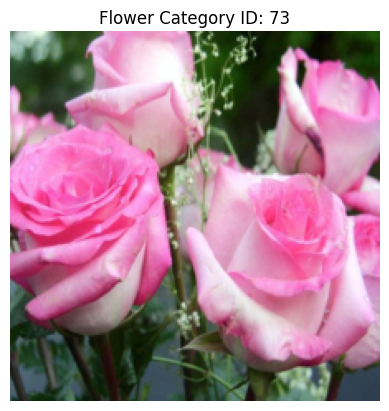

In [39]:
# Get one batch of images and labels
images, labels = next(iter(train_loader1))

# 'images' is a batch (e.g., [32, 3, 224, 224])
# Let's take the first image in that batch
first_img = images[0]
first_label = labels[0].item()

# Print and Show
print(f"Image Tensor Shape: {first_img.shape}")
print(f"Label ID: {first_label}")

show_image(first_img, first_label)

## models

# Importing Pre-trained Models
We'll install and import VGG19 from torchvision and YOLOv5. VGG19 is available directly through torchvision, while YOLOv5 needs to be installed separately.

In [3]:
!pip install torch torchvision ultralytics


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import torch
from torchvision.models import vgg19, VGG19_Weights
from ultralytics import YOLO

# Load VGG19 with pretrained weights
vgg_model = vgg19(weights=VGG19_Weights.DEFAULT)
vgg_model.eval()

# Load YOLOv5 
yolo_model = YOLO('yolov5s.pt')

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/tom/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100.0%


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



The models are now loaded and ready to use:
- VGG19: Pre-trained on ImageNet, useful for image classification tasks
- YOLOv5: Pre-trained on COCO dataset, useful for object detection tasks
Both models are in evaluation mode and can be used for inference.


## full pipeline using vgg

In [40]:
vgg_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [41]:
# freeze the features of vgg
for param in vgg_model.features.parameters():
    param.requires_grad = False


In [42]:
#replacing the head classifier
num_features = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = torch.nn.Linear(num_features, 102)


In [52]:
import torch.nn as nn
from torchvision import models

def setup_vgg():
    # 1. Load VGG19 with modern weight syntax
    # Use models.VGG19_Weights.DEFAULT instead of VGG19_Weights.DEFAULT
    vgg_model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)

    # 2. Freeze the 'Features' part
    for param in vgg_model.features.parameters():
        param.requires_grad = False

    # 3. Modify the 'Classifier'
    num_features = vgg_model.classifier[6].in_features

    # Replace the 1000-class layer with a 102-class layer
    vgg_model.classifier[6] = nn.Linear(num_features, 102)

    return vgg_model

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_transfer_learning(model, train_loader, val_loader, test_loader,  epochs=5, early_stopping=True, patience=3, min_delta=0.0, restore_best_weights=True):
    import copy
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    model.to(device)
    print(device)
    history = {'train_loss': [],'val_acc': [], 'test_acc': []}

    # Early stopping state
    best_metric = float('-inf')  # monitoring validation accuracy
    best_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        model.eval()
        total_val = 0
        correct_val = 0
        total_test = 0
        correct_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        test_acc = 100 * correct_test / total_test
        history['val_acc'].append(val_acc)
        history['test_acc'].append(test_acc)
        history['train_loss'].append(running_loss/len(train_loader))

        print(f"Epoch {epoch+1}/{epochs} - Loss: {history['train_loss'][-1]:.4f} - Val Acc: {val_acc:.2f}%  - Test Acc: {test_acc:.2f}%")

        # Early stopping check (monitoring validation accuracy)
        if early_stopping:
            current_metric = val_acc
            if current_metric > best_metric + min_delta:
                best_metric = current_metric
                best_state = copy.deepcopy(model.state_dict()) if restore_best_weights else None
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}. Best Val Acc: {best_metric:.2f}%")
                    break

    # Optionally restore the best weights observed during training
    if restore_best_weights and best_state is not None:
        model.load_state_dict(best_state)

    return model, history

In [53]:

print("\n---- Starting Run 1 (Split 1)----")
model_run1 = setup_vgg()
model_run1, history_run1 = train_transfer_learning(model_run1, train_loader1, val_loader1, test_loader1, epochs=10)


---- Starting Run 1 (Split 1)----
mps
Epoch 1/10 - Loss: 3.7223 - Val Acc: 45.75%  - Test Acc: 45.04%
Epoch 2/10 - Loss: 2.1222 - Val Acc: 64.11%  - Test Acc: 62.48%
Epoch 3/10 - Loss: 1.5747 - Val Acc: 67.48%  - Test Acc: 66.54%
Epoch 4/10 - Loss: 1.5135 - Val Acc: 68.31%  - Test Acc: 66.59%
Epoch 5/10 - Loss: 1.4461 - Val Acc: 72.41%  - Test Acc: 70.59%
Epoch 6/10 - Loss: 1.4052 - Val Acc: 71.97%  - Test Acc: 70.05%
Epoch 7/10 - Loss: 1.4314 - Val Acc: 73.39%  - Test Acc: 71.37%
Epoch 8/10 - Loss: 1.3376 - Val Acc: 74.95%  - Test Acc: 73.47%
Epoch 9/10 - Loss: 1.4279 - Val Acc: 72.71%  - Test Acc: 70.69%
Epoch 10/10 - Loss: 1.6637 - Val Acc: 75.29%  - Test Acc: 73.18%


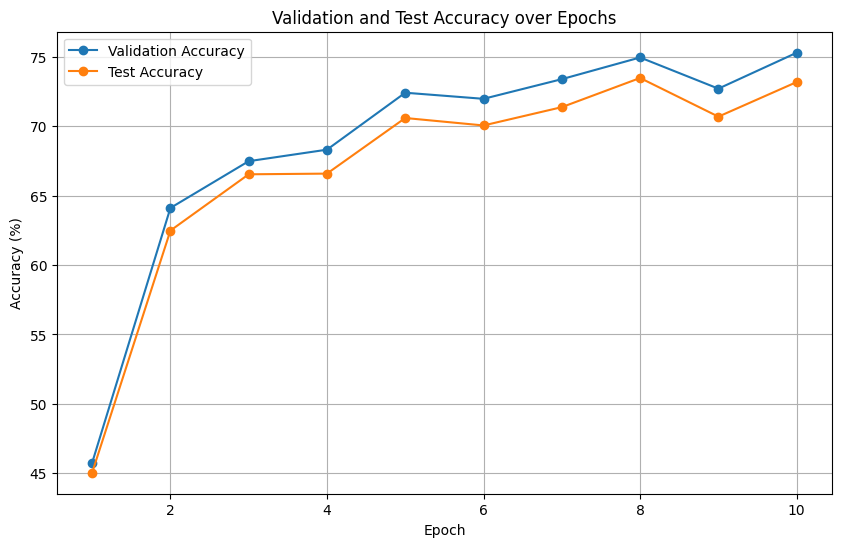

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history_run1['val_acc']) + 1), history_run1['val_acc'], label='Validation Accuracy', marker='o')
plt.plot(range(1, len(history_run1['test_acc']) + 1), history_run1['test_acc'], label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

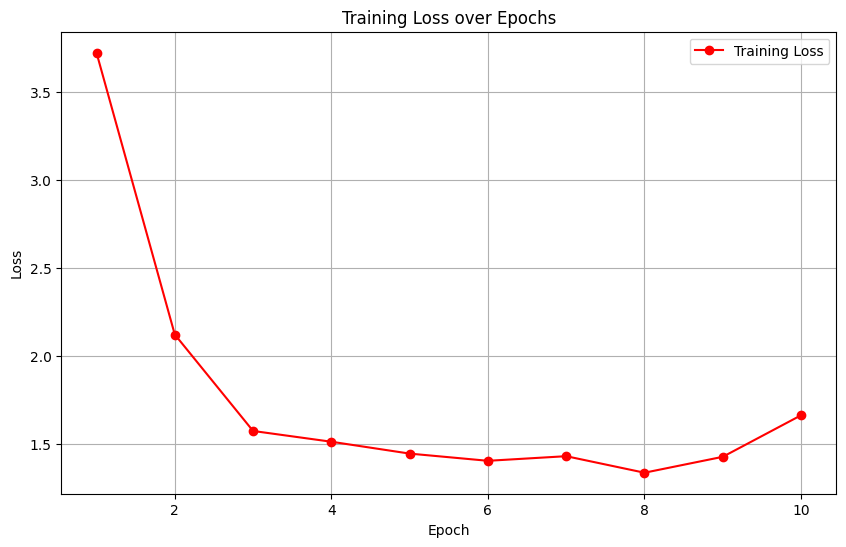

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history_run1['train_loss']) + 1), history_run1['train_loss'], label='Training Loss', marker='o',
         color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
print("\n---- Starting Run 2 (Split 2)----")
model_run2 = setup_vgg()
model_run2, history_run2 = train_transfer_learning(model_run2, train_loader2, val_loader2, test_loader2, epochs=10)


---- Starting Run 2 (Split 2)----
mps
Epoch 1/10 - Loss: 3.6011 - Val Acc: 52.64%  - Test Acc: 51.39%
Epoch 2/10 - Loss: 2.0851 - Val Acc: 64.99%  - Test Acc: 63.80%
Epoch 3/10 - Loss: 1.5398 - Val Acc: 70.51%  - Test Acc: 70.59%
Epoch 4/10 - Loss: 1.5239 - Val Acc: 68.02%  - Test Acc: 66.88%
Epoch 5/10 - Loss: 1.5325 - Val Acc: 73.19%  - Test Acc: 72.01%
Epoch 6/10 - Loss: 1.4063 - Val Acc: 74.37%  - Test Acc: 73.47%
Epoch 7/10 - Loss: 1.4714 - Val Acc: 72.85%  - Test Acc: 72.64%
Epoch 8/10 - Loss: 1.4154 - Val Acc: 71.83%  - Test Acc: 71.57%
Epoch 9/10 - Loss: 1.3018 - Val Acc: 74.41%  - Test Acc: 72.11%
Epoch 10/10 - Loss: 1.2857 - Val Acc: 74.17%  - Test Acc: 70.88%


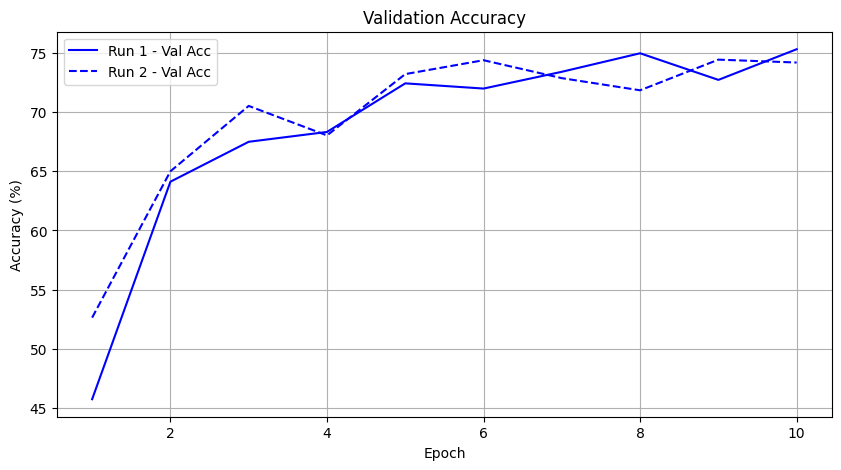

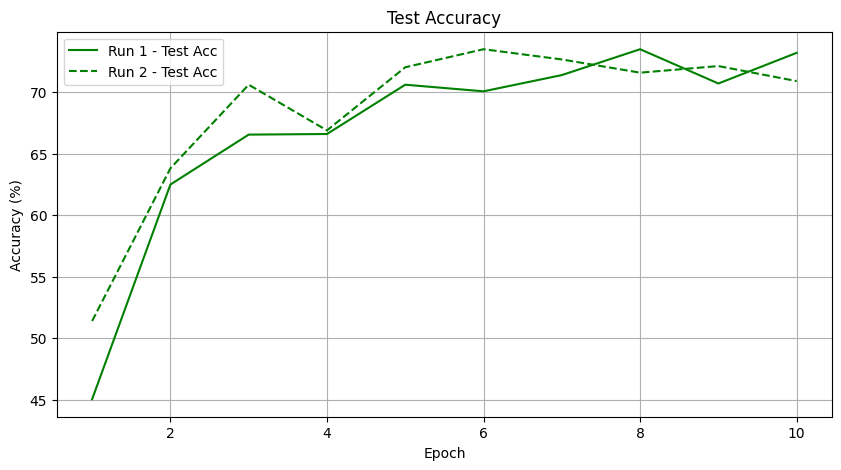

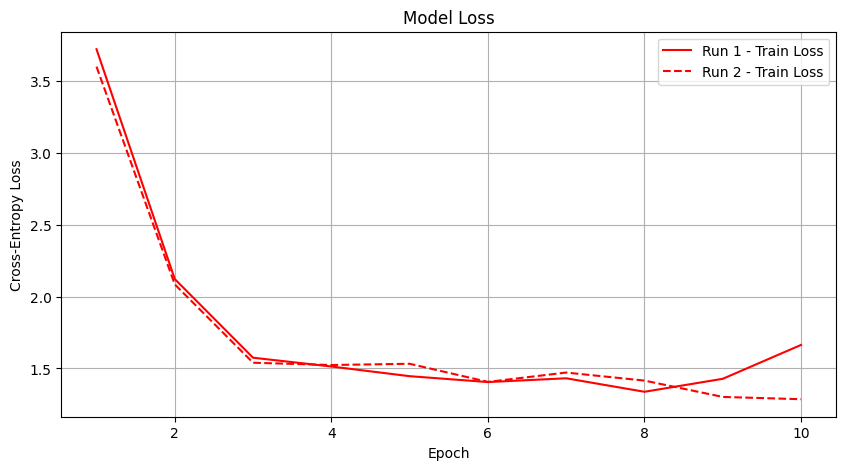

In [66]:
def plot_training_history(history1, history2=None):
    """Plot accuracy and loss metrics for model training runs"""
    # Plot validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history1['val_acc']) + 1), history1['val_acc'], 'b-', label='Run 1 - Val Acc')
    if history2:
        plt.plot(range(1, len(history2['val_acc']) + 1), history2['val_acc'], 'b--', label='Run 2 - Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot test accuracies 
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history1['test_acc']) + 1), history1['test_acc'], 'g-', label='Run 1 - Test Acc')
    if history2:
        plt.plot(range(1, len(history2['test_acc']) + 1), history2['test_acc'], 'g--', label='Run 2 - Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history1['train_loss']) + 1), history1['train_loss'], 'r-', label='Run 1 - Train Loss')
    if history2:
        plt.plot(range(1, len(history2['train_loss']) + 1), history2['train_loss'], 'r--', label='Run 2 - Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Model Loss')
    plt.grid(True)
    plt.legend()
    plt.show()


# Generate plots comparing both runs
plot_training_history(history_run1, history_run2)


## Augmented Dataset Variant (Train-time Data Augmentation)

In [72]:
import torch
from torch.utils.data import Dataset

# A lightweight wrapper that applies a transform to the image returned by any dataset (or Subset)
class TransformDataset(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]  # expects (PIL.Image, int) when base_dataset has transform=None
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# ImageNet normalization used by VGG19
_imagenet_mean = [0.485, 0.456, 0.406]
_imagenet_std = [0.229, 0.224, 0.225]

# Train-time augmentation for Flowers102
train_aug_transfor = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=_imagenet_mean, std=_imagenet_std),
])

# Evaluation (val/test) transform — same geometry as your baseline for consistency
_eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=_imagenet_mean, std=_imagenet_std),
])


def create_dataloaders_augmented(seed: int, batch_size: int = 32, num_workers: int = 0):
    """Create DataLoaders using the same Flowers102 data but with train-time augmentation.

    This function mirrors the stratified splitting used in create_dataloaders(seed),
    but it loads the raw Flowers102 (transform=None) and applies augmentation only
    to the training subset while keeping val/test deterministic.
    """
    from sklearn.model_selection import train_test_split
    import numpy as np
    from torch.utils.data import ConcatDataset, Subset, DataLoader
    from torchvision.datasets import Flowers102

    # Load raw datasets (no transform so we can apply our own later)
    train_raw = Flowers102(root="data", split="train", download=True, transform=None)
    val_raw = Flowers102(root="data", split="val", download=True, transform=None)
    test_raw = Flowers102(root="data", split="test", download=True, transform=None)

    # Concat to match the indexing scheme used before: [train_raw, val_raw, test_raw]
    full_raw = ConcatDataset([train_raw, val_raw, test_raw])

    # Collect labels in the same order to allow stratified splitting
    all_labels = np.concatenate([train_raw._labels, val_raw._labels, test_raw._labels])
    all_indices = np.arange(len(full_raw))

    # First split: 50% train, 50% temp (stratified)
    train_idx, temp_idx = train_test_split(
        all_indices, test_size=0.50, random_state=seed, stratify=all_labels
    )

    # Second split: equally divide temp into val/test (stratified)
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.50, random_state=seed, stratify=all_labels[temp_idx]
    )

    # Build Subsets from the raw concatenated dataset
    train_sub = Subset(full_raw, train_idx)
    val_sub = Subset(full_raw, val_idx)
    test_sub = Subset(full_raw, test_idx)

    # Wrap with transforms (augmentation on train, deterministic on val/test)
    train_ds_aug = TransformDataset(train_sub, transform=train_aug_transform)
    val_ds_eval = TransformDataset(val_sub, transform=_eval_transform)
    test_ds_eval = TransformDataset(test_sub, transform=_eval_transform)

    # DataLoaders (keep shuffle for train only)
    train_loader = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds_eval, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_ds_eval, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


In [75]:
# Example: create augmented loaders for the same two seeds used earlier
train_loader1_aug, val_loader1_aug, test_loader1_aug = create_dataloaders_augmented(seed=42)
train_loader2_aug, val_loader2_aug, test_loader2_aug = create_dataloaders_augmented(seed=2026)

print("Augmented loaders ready:",
      f"Train1 batches: {len(train_loader1_aug)} | Train2 batches: {len(train_loader2_aug)}")

# If you want to train with augmentation, you can do e.g.:
model_aug = setup_vgg()
model_aug, history_aug = train_transfer_learning(
    model_aug, train_loader1_aug, val_loader1_aug, test_loader1_aug, epochs=10
)


Augmented loaders ready: Train1 batches: 128 | Train2 batches: 128
Epoch 1/10 - Loss: 3.0725 - Val Acc: 61.65%  - Test Acc: 61.87%
Epoch 2/10 - Loss: 1.3625 - Val Acc: 72.55%  - Test Acc: 74.41%
Epoch 3/10 - Loss: 0.8625 - Val Acc: 76.80%  - Test Acc: 78.91%
Epoch 4/10 - Loss: 0.6281 - Val Acc: 80.36%  - Test Acc: 82.81%
Epoch 5/10 - Loss: 0.4547 - Val Acc: 82.22%  - Test Acc: 84.86%
Epoch 6/10 - Loss: 0.3650 - Val Acc: 81.24%  - Test Acc: 84.62%
Epoch 7/10 - Loss: 0.3047 - Val Acc: 82.02%  - Test Acc: 85.06%
Epoch 8/10 - Loss: 0.2384 - Val Acc: 82.90%  - Test Acc: 86.57%
Epoch 9/10 - Loss: 0.2136 - Val Acc: 82.90%  - Test Acc: 85.79%
Epoch 10/10 - Loss: 0.1880 - Val Acc: 84.07%  - Test Acc: 86.08%


Epoch 1/10 - Loss: 3.0282 - Val Acc: 63.80%  - Test Acc: 62.65%
Epoch 2/10 - Loss: 1.3569 - Val Acc: 73.52%  - Test Acc: 74.95%
Epoch 3/10 - Loss: 0.8656 - Val Acc: 79.09%  - Test Acc: 80.42%
Epoch 4/10 - Loss: 0.6121 - Val Acc: 81.19%  - Test Acc: 81.79%
Epoch 5/10 - Loss: 0.4743 - Val Acc: 80.26%  - Test Acc: 81.98%
Epoch 6/10 - Loss: 0.3833 - Val Acc: 83.88%  - Test Acc: 83.94%
Epoch 7/10 - Loss: 0.3311 - Val Acc: 83.63%  - Test Acc: 84.33%
Epoch 8/10 - Loss: 0.2629 - Val Acc: 83.63%  - Test Acc: 83.59%
Epoch 9/10 - Loss: 0.1828 - Val Acc: 83.29%  - Test Acc: 85.11%
Early stopping triggered at epoch 9. Best Val Acc: 83.88%


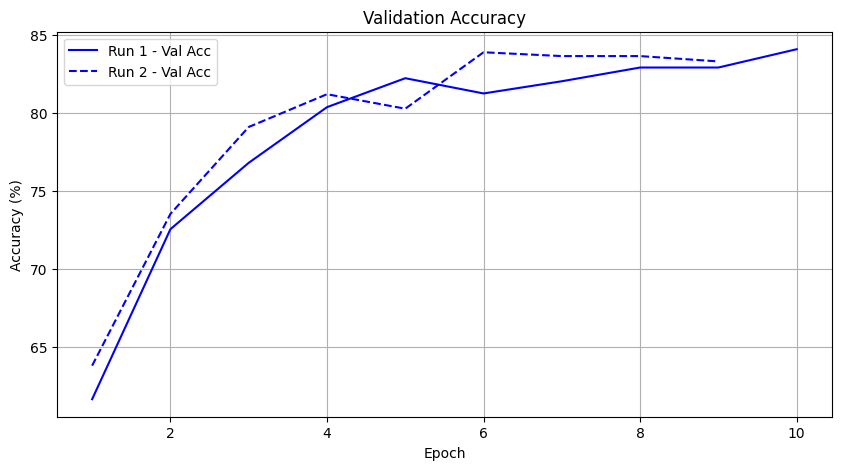

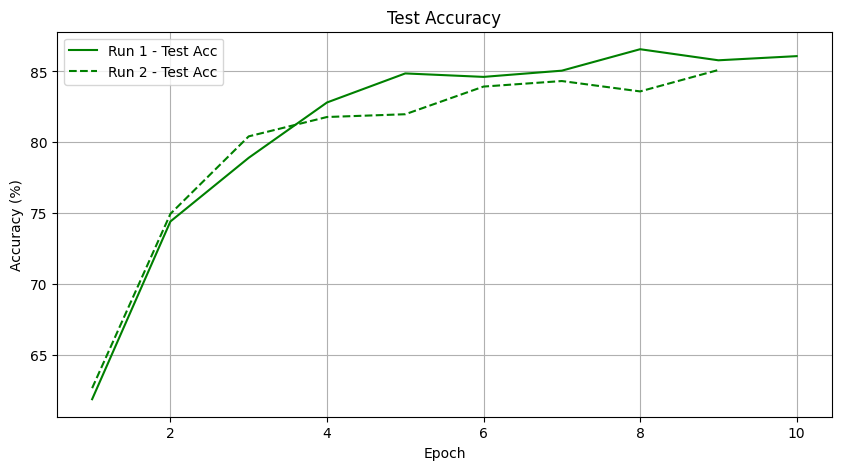

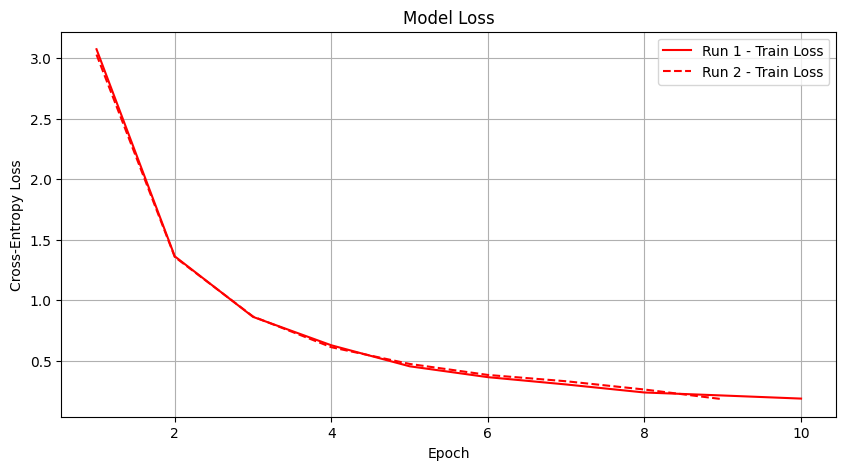

In [76]:
# Train with augmented data loader 2
model_aug2 = setup_vgg()
model_aug2, history_aug2 = train_transfer_learning(
    model_aug2, train_loader2_aug, val_loader2_aug, test_loader2_aug, epochs=10
)

# Plot results comparing both augmented runs
plot_training_history(history_aug, history_aug2)


## YOLOv5

## YOLOv5 — Transfer Learning for Flowers102 (Classification via Backbone)

In [93]:
import os
import torch
import torch.nn as nn
from ultralytics import YOLO

class YOLOBackboneClassifier(nn.Module):
    """
    Robust YOLO feature-extractor wrapper for classification.

    Instead of trying to rebuild the YOLO backbone with nn.Sequential (which breaks
    Ultralytics' dynamic graph/skip-connections), we:
      - Keep the original YOLO detection model intact
      - Register a forward-pre-hook on the Detect head to capture its input feature
        maps (P3, P4, P5). These are the multi-scale backbone outputs.
      - Apply GAP on each map and concatenate pooled vectors
      - Train a small Linear head to 102 classes

    Only the classification head is trainable by default (backbone frozen).
    """
    def __init__(self, yolo_core: nn.Module, num_classes: int = 102, freeze_backbone: bool = True, input_size: int = 224):
        super().__init__()
        self.yolo = yolo_core  # full Ultralytics detection Model
        self._feats = None
        self.pool = nn.AdaptiveAvgPool2d((1, 1))


        # Find the Detect module (last head) to hook its inputs (multi-scale features)
        self._detect = None
        for m in self.yolo.modules():
            name = m.__class__.__name__.lower()
            if 'detect' in name:  # matches Detect / SegmentDetect variations
                self._detect = m
        if self._detect is None:
            raise RuntimeError("Could not find YOLO Detect head to hook features.")

        # Register hook that captures the feature list passed into Detect.forward(...)
        def _capture_pre_hook(module, inputs):
            # inputs is a tuple; first item is the list/tuple of feature maps
            if inputs and len(inputs) > 0:
                self._feats = inputs[0]
        self._hook = self._detect.register_forward_pre_hook(_capture_pre_hook)

        # Optionally freeze the entire YOLO detector (backbone + neck)
        if freeze_backbone:
            for p in self.yolo.parameters():
                p.requires_grad = False

        for p in list(self.yolo.parameters())[-4:]:
            for param in p:
                param.requires_grad = True

        # Infer classifier input channels via a dummy pass
        with torch.no_grad():
            was_training = self.yolo.training
            self.yolo.eval()
            dev = next(self.yolo.parameters()).device
            dummy = torch.zeros(1, 3, input_size, input_size, device=dev)
            _ = self.yolo(dummy)  # triggers hook, sets self._feats
            feats = self._feats
            if isinstance(feats, (list, tuple)):
                c_total = sum([f.shape[1] for f in feats])
            else:
                c_total = feats.shape[1]
            # restore state
            if was_training:
                self.yolo.train()

        self.head = nn.Linear(c_total, num_classes)
        # self.head = nn.Sequential(
        # nn.Linear(c_total, 512),
        # nn.BatchNorm1d(512),
        # nn.ReLU(),
        # nn.Dropout(0.3), # Essential for small datasets like 102 Flowers
        # nn.Linear(c_total, num_classes)
        # )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Ensure YOLO lives on the same device as input
        if next(self.yolo.parameters()).device != x.device:
            self.yolo.to(x.device)

        # Run detection model under no_grad to save memory if backbone is frozen
        if all(p.requires_grad is False for p in self.yolo.parameters()):
            with torch.no_grad():
                _ = self.yolo(x)
        else:
            _ = self.yolo(x)

        feats = self._feats
        if isinstance(feats, (list, tuple)):
            pooled = []
            for f in feats:
                f = self.pool(f)
                f = torch.flatten(f, 1)
                pooled.append(f)
            x = torch.cat(pooled, dim=1)
        else:
            x = self.pool(feats)
            x = torch.flatten(x, 1)
        x = self.head(x)
        return x

    def remove_hook(self):
        try:
            if hasattr(self, '_hook') and self._hook is not None:
                self._hook.remove()
        except Exception:
            pass


def setup_yolo_classifier(num_classes: int = 102, freeze_backbone= True):
    """
    Load a YOLO detection model (weights from local file if available), wrap it as a
    classification model with a frozen backbone and a new 102-class head.
    Returns a plain nn.Module compatible with the existing training loop.
    """
    # Prefer local weights if present (offline-friendly), else default to yolov5s.pt
    weights_path = 'yolov5su.pt' if os.path.exists('yolov5su.pt') else 'yolov5s.pt'
    base = YOLO(weights_path)
    yolo_core = base.model  # underlying nn.Module (Ultralytics Model)
    clf = YOLOBackboneClassifier(yolo_core, num_classes=num_classes, freeze_backbone=freeze_backbone, input_size=224)
    return clf



==== YOLO — Starting Run 1 (Split 1) ====

mps
Epoch 1/50 - Loss: 4.5720 - Val Acc: 4.30%  - Test Acc: 4.15%
Epoch 2/50 - Loss: 4.4688 - Val Acc: 5.91%  - Test Acc: 5.57%
Epoch 3/50 - Loss: 4.3987 - Val Acc: 6.89%  - Test Acc: 7.03%
Epoch 4/50 - Loss: 4.3434 - Val Acc: 8.06%  - Test Acc: 8.11%
Epoch 5/50 - Loss: 4.2938 - Val Acc: 9.38%  - Test Acc: 9.33%
Epoch 6/50 - Loss: 4.2462 - Val Acc: 10.45%  - Test Acc: 10.60%
Epoch 7/50 - Loss: 4.2019 - Val Acc: 11.38%  - Test Acc: 11.28%
Epoch 8/50 - Loss: 4.1592 - Val Acc: 12.16%  - Test Acc: 11.67%
Epoch 9/50 - Loss: 4.1183 - Val Acc: 12.55%  - Test Acc: 12.30%
Epoch 10/50 - Loss: 4.0803 - Val Acc: 12.95%  - Test Acc: 13.04%
Epoch 11/50 - Loss: 4.0428 - Val Acc: 13.97%  - Test Acc: 14.01%
Epoch 12/50 - Loss: 4.0053 - Val Acc: 14.46%  - Test Acc: 14.40%
Epoch 13/50 - Loss: 3.9694 - Val Acc: 15.19%  - Test Acc: 15.09%
Epoch 14/50 - Loss: 3.9337 - Val Acc: 16.12%  - Test Acc: 16.02%
Epoch 15/50 - Loss: 3.9003 - Val Acc: 16.51%  - Test Acc: 16.

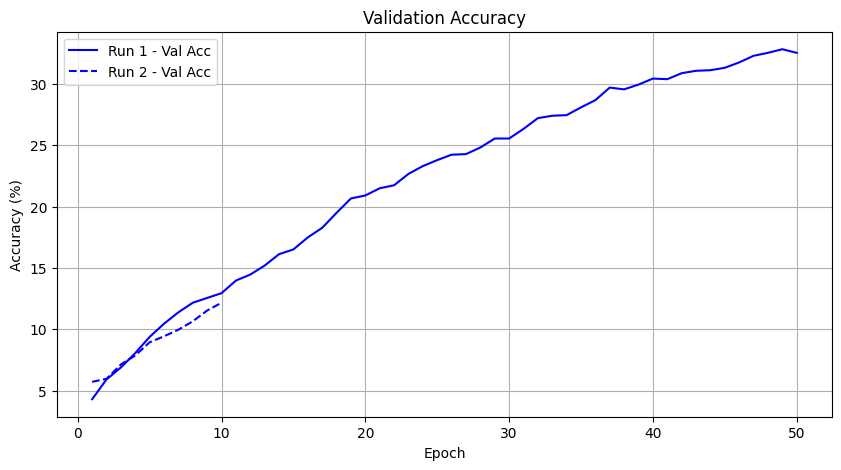

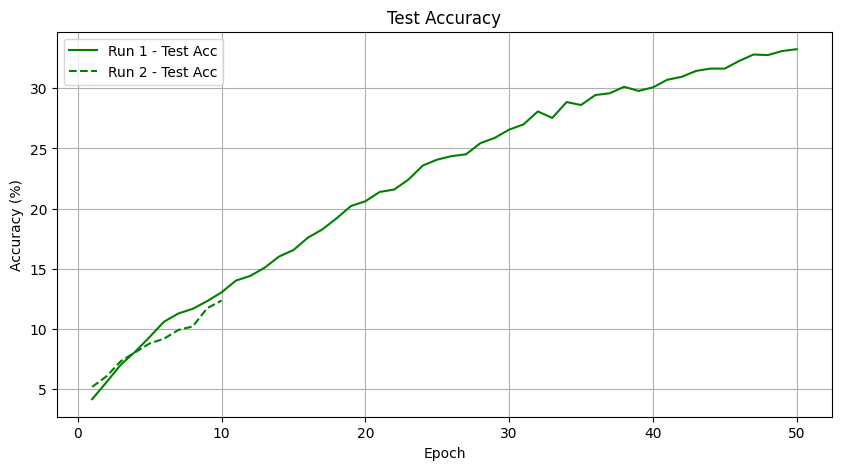

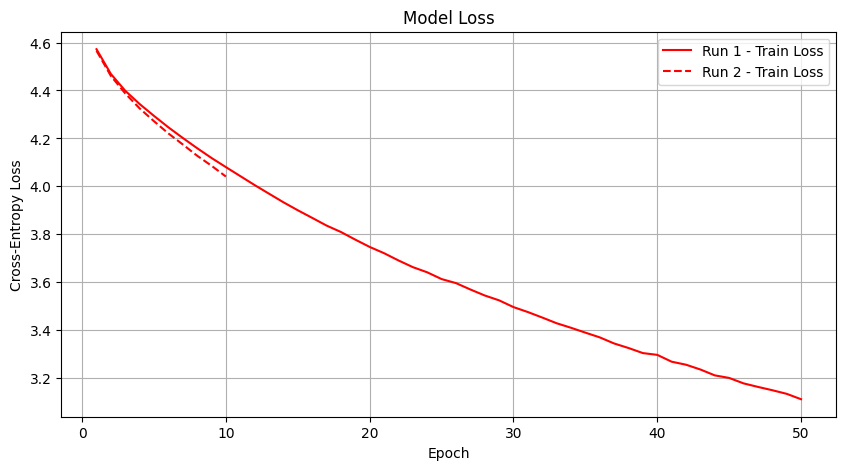

In [106]:
# Non-augmented YOLO experiments (same seeds and protocol as VGG)
print("\n==== YOLO — Starting Run 1 (Split 1) ====\n")
yolo_cls_run1 = setup_yolo_classifier(num_classes=102, freeze_backbone = False)
yolo_cls_run1, yolo_history_run1 = train_transfer_learning(
    yolo_cls_run1, train_loader1_yolo448, val_loader1_yolo448, test_loader1_yolo448, epochs=50
)

print("\n==== YOLO — Starting Run 2 (Split 2) ====\n")
yolo_cls_run2 = setup_yolo_classifier(num_classes=102, freeze_backbone = False)
yolo_cls_run2, yolo_history_run2 = train_transfer_learning(
    yolo_cls_run2, train_loader2, val_loader2, test_loader2, epochs=10
)

# Compare runs (validation/test accuracy and training loss)
plot_training_history(yolo_history_run1, yolo_history_run2)


### YOLO with Train-time Augmentation (same as VGG augmented section)


==== YOLO (Augmented) — Starting Run 1 (Split 1) ====

mps
Epoch 1/100 - Loss: 4.5694 - Val Acc: 4.98%  - Test Acc: 4.64%
Epoch 2/100 - Loss: 4.4646 - Val Acc: 6.25%  - Test Acc: 6.35%
Epoch 3/100 - Loss: 4.3925 - Val Acc: 7.08%  - Test Acc: 7.08%
Epoch 4/100 - Loss: 4.3367 - Val Acc: 7.91%  - Test Acc: 7.81%
Epoch 5/100 - Loss: 4.2852 - Val Acc: 8.60%  - Test Acc: 8.20%
Epoch 6/100 - Loss: 4.2425 - Val Acc: 9.18%  - Test Acc: 8.69%
Epoch 7/100 - Loss: 4.1957 - Val Acc: 9.43%  - Test Acc: 9.52%
Epoch 8/100 - Loss: 4.1574 - Val Acc: 9.92%  - Test Acc: 9.81%
Epoch 9/100 - Loss: 4.1160 - Val Acc: 10.16%  - Test Acc: 10.40%
Epoch 10/100 - Loss: 4.0811 - Val Acc: 10.65%  - Test Acc: 10.69%
Epoch 11/100 - Loss: 4.0486 - Val Acc: 11.24%  - Test Acc: 11.38%
Epoch 12/100 - Loss: 4.0117 - Val Acc: 11.72%  - Test Acc: 12.21%
Epoch 13/100 - Loss: 3.9773 - Val Acc: 12.41%  - Test Acc: 12.65%
Epoch 14/100 - Loss: 3.9460 - Val Acc: 12.60%  - Test Acc: 13.43%
Epoch 15/100 - Loss: 3.9089 - Val Acc: 13

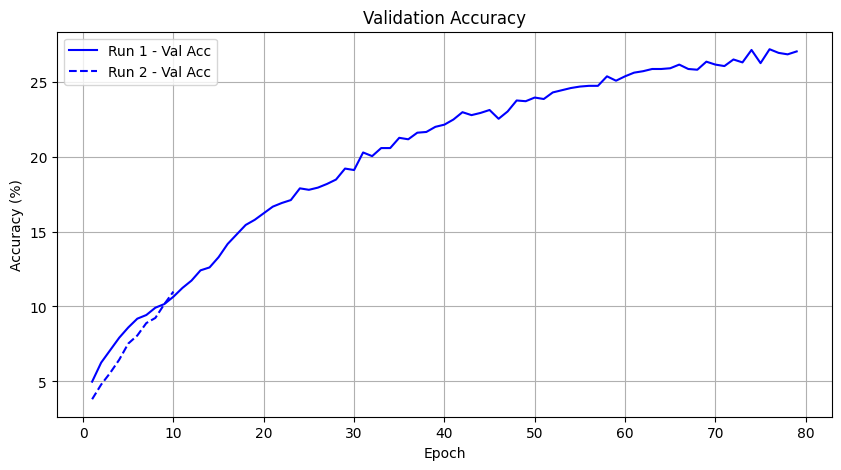

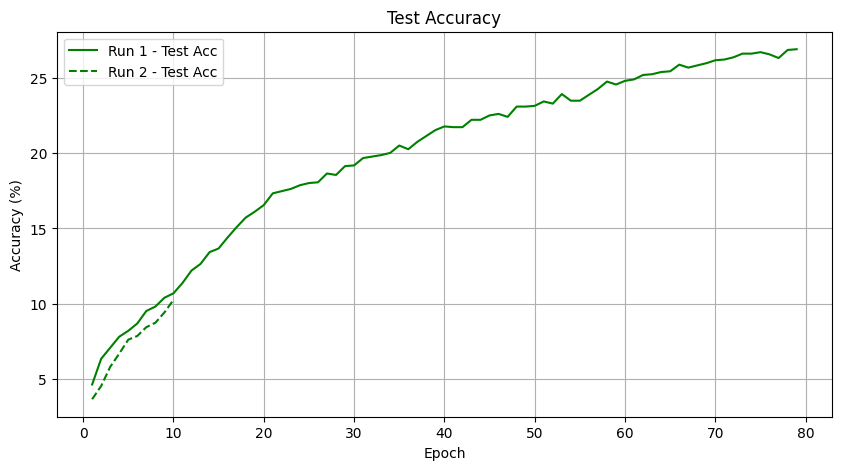

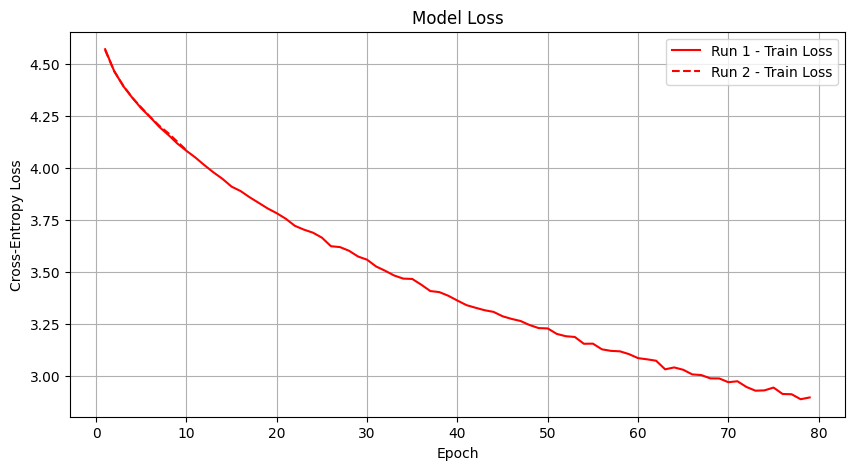

In [94]:
print("\n==== YOLO (Augmented) — Starting Run 1 (Split 1) ====\n")
yolo_cls_aug1 = setup_yolo_classifier(num_classes=102, freeze_backbone = True)
yolo_cls_aug1, yolo_history_aug1 = train_transfer_learning(
    yolo_cls_aug1, train_loader1_aug, val_loader1_aug, test_loader1_aug, epochs=100
)

print("\n==== YOLO (Augmented) — Starting Run 2 (Split 2) ====\n")
yolo_cls_aug2 = setup_yolo_classifier(num_classes=102)
yolo_cls_aug2, yolo_history_aug2 = train_transfer_learning(
    yolo_cls_aug2, train_loader2_aug, val_loader2_aug, test_loader2_aug, epochs=10
)

# Compare augmented runs
plot_training_history(yolo_history_aug1, yolo_history_aug2)


In [95]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

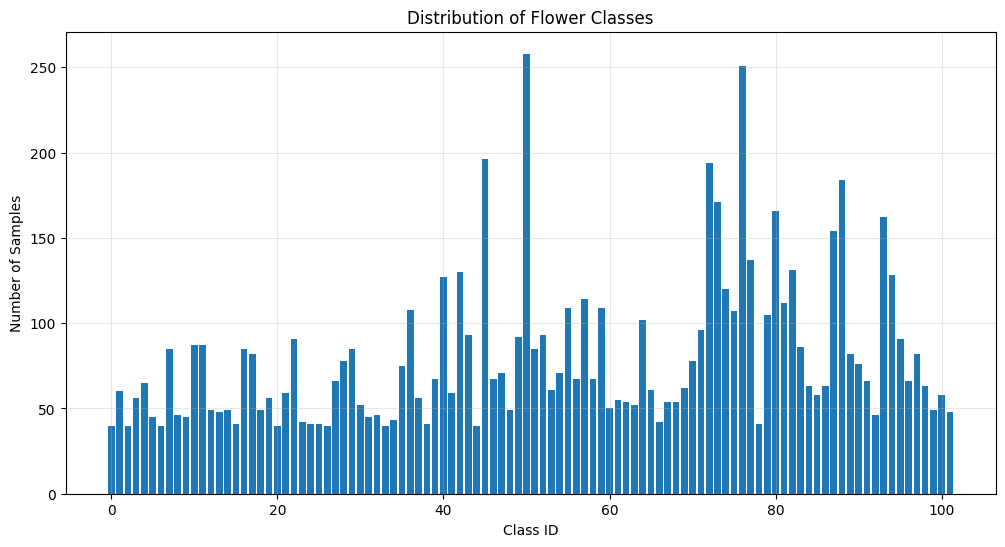

In [99]:
plt.figure(figsize=(12, 6))
plt.hist(all_labels, bins=np.arange(103) - 0.5, rwidth=0.8)
plt.title('Distribution of Flower Classes')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.grid(True, alpha=0.3)
plt.show()


In [100]:
all_indices

array([   0,    1,    2, ..., 8186, 8187, 8188], shape=(8189,))

np.int64(1)

IndexError: invalid index to scalar variable.

## YOLOv5 — 448px Data Loaders (for classification via YOLO backbone)

In [104]:
from torchvision import transforms
from torchvision.datasets import Flowers102
from torch.utils.data import ConcatDataset, Subset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import torch

# 448px evaluation transform (ImageNet normalization)
_eval_transform_448 = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def create_dataloaders_yolo_448(seed: int, batch_size: int = 32, num_workers: int = 0):
    """Create non-augmented DataLoaders at 448x448 resolution for YOLO experiments.

    - Mirrors the stratified 50/25/25 split used elsewhere.
    - Loads raw Flowers102 (transform=None) and applies a 448 eval transform to
      train/val/test for consistency.
    - Keep shuffle=True for train only.
    """
    # Load raw datasets (no transforms baked in)
    train_raw = Flowers102(root="data", split="train", download=True, transform=None)
    val_raw = Flowers102(root="data", split="val", download=True, transform=None)
    test_raw = Flowers102(root="data", split="test", download=True, transform=None)

    # Concat to match indexing scheme
    full_raw = ConcatDataset([train_raw, val_raw, test_raw])

    # Labels and indices for stratified splitting
    all_labels = np.concatenate([train_raw._labels, val_raw._labels, test_raw._labels])
    all_indices = np.arange(len(full_raw))

    # First split: 50% train, 50% temp (stratified)
    train_idx, temp_idx = train_test_split(
        all_indices, test_size=0.50, random_state=seed, stratify=all_labels
    )

    # Second split: 25% val, 25% test (stratified)
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.50, random_state=seed, stratify=all_labels[temp_idx]
    )

    # Build Subsets from the raw concatenated dataset
    train_sub = Subset(full_raw, train_idx)
    val_sub = Subset(full_raw, val_idx)
    test_sub = Subset(full_raw, test_idx)

    # Wrap subsets with 448 eval transform (no augmentation here)
    # Note: TransformDataset class is defined earlier in the notebook.
    train_ds_448 = TransformDataset(train_sub, transform=_eval_transform_448)
    val_ds_448 = TransformDataset(val_sub, transform=_eval_transform_448)
    test_ds_448 = TransformDataset(test_sub, transform=_eval_transform_448)

    # DataLoaders
    train_loader = DataLoader(train_ds_448, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds_448, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_ds_448, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


In [105]:
# Example usage for the two seeds used elsewhere
train_loader1_yolo448, val_loader1_yolo448, test_loader1_yolo448 = create_dataloaders_yolo_448(seed=42)
train_loader2_yolo448, val_loader2_yolo448, test_loader2_yolo448 = create_dataloaders_yolo_448(seed=2026)

# Quick shape sanity check (expect images of shape [B, 3, 448, 448])
imgs_448, labels_448 = next(iter(train_loader1_yolo448))
print("YOLO 448 batch shape:", tuple(imgs_448.shape))


YOLO 448 batch shape: (32, 3, 448, 448)
